In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

Variable

Description

Gender	:    1 for female, 2 for male

Words	:    Time in seconds to read 60 color words (in black ink)

Colors	:    Time in seconds to name 60 color rectangles

Interfer:	Time in seconds to name colors of conflicting words


In [3]:
stroop_df = pd.read_csv('data/stroop.txt', sep=' ')

In [4]:
stroop_df.head()

,gender,words,colors,interfer
0,1,14,17,38
1,1,17,15,58
2,1,17,18,35
3,1,16,20,39
4,1,16,18,33


Text(0.5, 1.0, 'Interference')

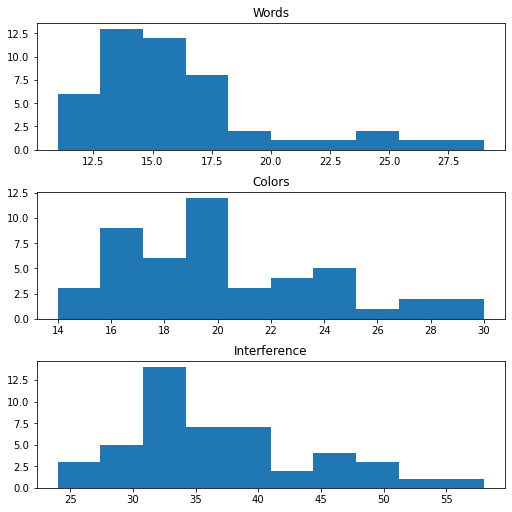

In [5]:
fig, axes = plt.subplots(3, figsize=(7, 7), constrained_layout=True)

axes[0].hist(stroop_df['words'])
axes[1].hist(stroop_df['colors'])
axes[2].hist(stroop_df['interfer'])

axes[0].set_title('Words')
axes[1].set_title('Colors')
axes[2].set_title('Interference')

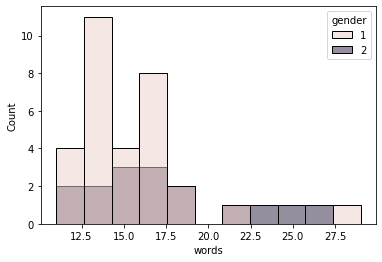

In [6]:
sns.histplot(x='words', data=stroop_df, hue='gender')

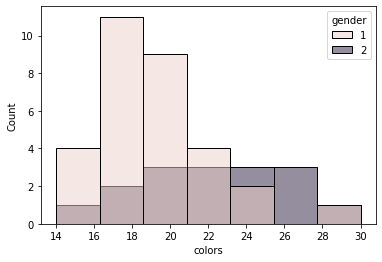

In [7]:
sns.histplot(x='colors', data=stroop_df, hue='gender')

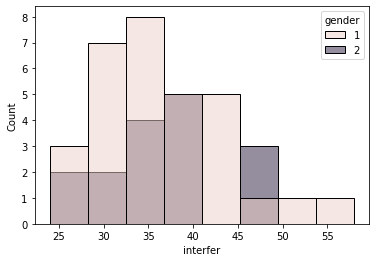

In [8]:
sns.histplot(x='interfer', data=stroop_df, hue='gender')

In [9]:
stroop_df.describe()

,gender,words,colors,interfer
count,47.000000,47.000000,47.000000,47.000000
mean,1.340426,16.085106,20.234043,36.595745
std,0.478975,3.971802,3.731259,7.421062
min,1.000000,11.000000,14.000000,24.000000
25%,1.000000,14.000000,17.500000,32.000000
50%,1.000000,15.000000,20.000000,35.000000
75%,2.000000,17.000000,22.500000,40.000000
max,2.000000,29.000000,30.000000,58.000000


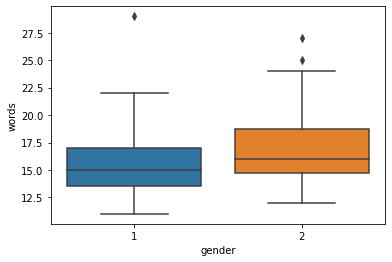

In [10]:
sns.boxplot(x='gender', y='words', data=stroop_df)

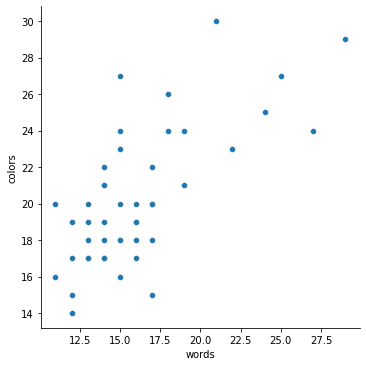

In [11]:
sns.relplot(x='words', y='colors', data=stroop_df, kind='scatter')

Covariance between two variables X, Y is defined as
\$COV(X, Y) = E(XY) - EXEY\$

here we have covariance matrix, defined as follows 
\$[[D^{2}X, cov(X, Y)],
[cov(X, Y), D^{2}Y]]\$

and correlation coefficient as
\$p = \frac{COV(X, Y)}{\sigma_{X}\sigma_{Y}}\$

In [12]:
p = stroop_df['colors'].corr(stroop_df['words'])
print(p)

cov_matrix = np.cov(stroop_df['colors'].values, stroop_df['words'].values)
print(cov_matrix)
cov_xy = cov_matrix[0, 1]
s_x, s_y = cov_matrix[0, 0], cov_matrix[1, 1]

p = cov_xy / (np.sqrt(s_x * s_y))
p

0.7012697451964958
[[13.92229417 10.39269195]
 [10.39269195 15.77520814]]


0.7012697451964958

[[17.11111111  5.77777778]
 [ 5.77777778  5.51111111]]


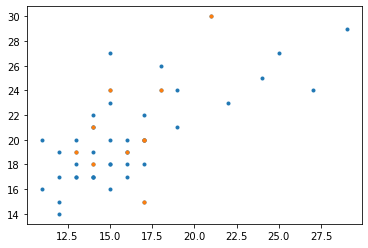

In [13]:
fastest_color_namers = stroop_df.nlargest(10, 'interfer')
print(np.cov(fastest_color_namers['colors'], fastest_color_namers['words']))

plt.plot(stroop_df['words'], stroop_df['colors'], marker='.', linestyle='none')
plt.plot(fastest_color_namers['words'], fastest_color_namers['colors'], marker='.', linestyle='none')

Performing a t-test comparing males and females on color

The assumption of normality is made, even though it is rather not met (look at the histogram above)

In [14]:
females = stroop_df.loc[stroop_df['gender'] == 1, 'colors']
males = stroop_df.loc[stroop_df['gender'] == 2, 'colors']

f_mean = np.mean(females)
m_mean = np.mean(males)

f_var = np.var(females)
m_var = np.var(males)

n_f = females.size
n_m = males.size

t_stat = (f_mean - m_mean) / np.sqrt((n_f * f_var + n_m * m_var) / (n_f + n_m - 2) * (1 / n_f + 1 / n_m))
t_stat

-2.8614138622402745

In [15]:
from scipy.stats import t

p = 0.05

t.cdf(t_stat, (n_f + n_m - 2)) < p

True

So we reject the null hypothesis that the means are equal

Next, we'll compute 95% confidence interval for interference. 
Since we don't know the mean and the variance, we'll use t-statistic for the mean

\$X - t(1 - \frac{\alpha}{2}, n - 1)\frac{S}{\sqrt{n - 1}} < \mu < X + t(1 - \frac{\alpha}{2}, n - 1)\frac{S}{\sqrt{n - 1}} \$

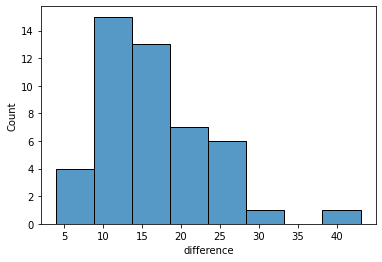

In [16]:
stroop_df['difference'] = stroop_df['interfer'] - stroop_df['colors']
sns.histplot(x='difference', data=stroop_df)

In [17]:
diff_mean = stroop_df['difference'].mean()
diff_s = np.std(stroop_df['difference'], ddof=1) #default is 1
n = stroop_df.shape[0]

alpha = 0.05
t_stat = t.ppf(1 - alpha/2, n - 1)
term = t_stat * (diff_s / np.sqrt(n - 1))
(diff_mean - term, diff_mean + term)

(14.14471203145878, 18.578692223860365)

#### Confidence intervals for the variance 

###### Model 1
If the population has normal distribution with unknown parameters, then we create \$ 1 - \alpha\$ confidence interval using statistic $$ Z = \frac{nS^2}{\sigma^2}$$ which has \$ \chi^2 \$ distribution with \$ n - 1 \$ degrees of freedom

Then the two-sided interval is as follows

$$ \sigma^2 : (\frac{n}{\chi^2(1 - \frac{\alpha}{2}, n - 1)} S^2, \frac{n}{\chi^2(\frac{\alpha}{2}, n - 1)} S^2) $$

$$ \sigma : (\sqrt{\frac{n}{\chi^2(1 - \frac{\alpha}{2}, n - 1)}} S, \sqrt{\frac{n}{\chi^2(\frac{\alpha}{2}, n - 1)}} S) $$

In [18]:
from scipy.stats import chi2
# Let's compute the interval for the variance in the
# difference column

diff_var = stroop_df['difference'].var(ddof=0)
n = len(stroop_df)
alpha = 0.05

print("variance = ", diff_var)
print("sample size = ", n)

left_end = n * diff_var / chi2.ppf(1 - alpha / 2, n - 1)
right_end = n * diff_var / chi2.ppf(alpha / 2, n - 1)
print("variance: ", (left_end, right_end))
print("standard deviation: ", (np.sqrt(left_end), np.sqrt(right_end)))

variance =  54.61385242191038
sample size =  47
variance:  (38.53174446432523, 88.02627928288396)
standard deviation:  (6.207394337749554, 9.382232105575088)


###### Model 2
If the population size >= 30, then we can use the fact that \$ S \sim N(\sigma, \frac{\sigma}{\sqrt{2n}})\$. So the confidence interval will be 
$$ \sigma : (\frac{S\sqrt{2n}}{\sqrt{2n} + u(1 - \frac{\alpha}{2})}; \frac{S\sqrt{2n}}{\sqrt{2n} - u(1 - \frac{\alpha}{2})})$$

We'll use this for the previous computations

In [19]:
from scipy.stats import norm

assert n >= 30

q = norm.ppf(1 - alpha / 2)
diff_std = np.sqrt(diff_var)
a = np.sqrt(2 * n)
nominator = diff_std * a
left_end = nominator / (a + q)
right_end = nominator / (a - q)

print("variance: ", (left_end ** 2, right_end ** 2))
print("standard deviation: ", (left_end, right_end))

variance:  (37.79044334619631, 85.79571407855443)
standard deviation:  (6.147393215517965, 9.262597588071849)


### Minimal Sample Size

###### Model 1
A population has normal distribution with known \$ \sigma \$, then for the interval length \$ 2d \$ we can find the minimum sample size

$$ n \geq (\frac{u(1 - \frac{\alpha}{2}) \sigma}{d})^2$$

###### Model 2
A population has normal distribution with unknown \$ \sigma \$, then for the interval length \$ 2d \$ we apply 2-step method

The interval length is 

$$ 2t(1 - \frac{\alpha}{2}; n - 1)\frac{S}{\sqrt{n - 1}} $$

We can't calculate it until we know the sample size. So we do the following

1. Draw a pilot sample of size \$ n_o \$
2. Compute \$ \overline x_o = \frac{1}{n_o}\sum_{i = 1}^{n_o} x_i\$, \$ S^2 = \frac{1}{n_o}\sum_{i = 1}^{n_o} (x_i - \overline x_o)^2\$
3. If \$ n_o \geq k = (t(1 - \frac{\alpha}{2}; n_o - 1)\frac{S}{d})^2 + 1\$, then the sample size is enough
4. Otherwise, draw the second sample of size \$ n = [k] - n_o + 1\$, where [x] is the integer part of a number
5. Recompute \$ \overline x = \frac{1}{n_o + n}\sum_{i = 1}^{n_o + n} x_i\$ (note that the sample variance is not recomputed!)

The confidence interval is then
$$ (\overline x - t(1 - \frac{\alpha}{2}; n + n_o - 1)\frac{S}{\sqrt{n + n_o - 1}}; \overline x + t(1 - \frac{\alpha}{2}; n + n_o - 1)\frac{S}{\sqrt{n + n_o - 1}})$$

In [26]:
from scipy.stats import t
# Assume we want to such n so that the 95% confidence interval length is 
# 2d = 2 sec for the difference column in the stroop data

alpha = 0.05
d = 1
n_o = len(stroop_df['difference'])
print(n_o)

diff_std = stroop_df['difference'].std(ddof=0)

qt = t.ppf(1 - alpha / 2, n_o - 1)
k = (qt * diff_std / d) ** 2 + 1

print(n_o >= k)

n = np.floor(k) - n_o + 1
print(n)

47
False
176.0
